In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv


Loading data

In [2]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
y = train_data['label']
X = train_data.drop(['label'],axis=1)

In [4]:
del train_data

Checking for null values

In [5]:
X.isnull().all().unique()

array([False])

In [6]:
y.isnull().any()

False

In [7]:
test_data.isnull().all().unique()

array([False])

Therefore we dont have any null values in both our test and train data

# Visualization

Lets plot the distributiom of labels

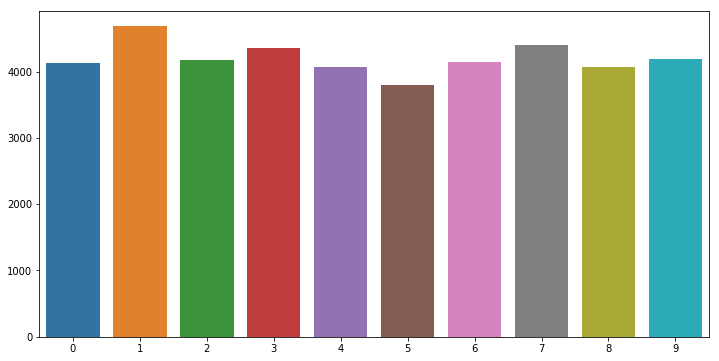

In [8]:
label_val = y.value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=label_val.index,y=label_val.values)

Distribution of labels is relatively similar

Right now we have flat pixels but our image should be a 2d image with single channel ( since we have grayscale images)

So lets reshape the arrays

In [9]:
X = X.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

Plotting a single digit

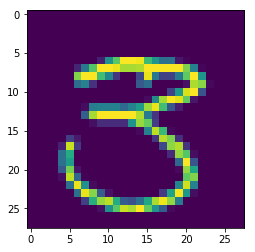

In [10]:
plt.imshow(X[7][:,:,0])

In [11]:
X = X / 255
test_data = test_data / 255

Now we have the data to work with , so lets start building the model using Keras

In [12]:
import warnings

In [13]:
warnings.filterwarnings('ignore')

# Model building

In [14]:
%%time
from keras.models import Sequential

Using TensorFlow backend.


CPU times: user 1.65 s, sys: 296 ms, total: 1.94 s
Wall time: 3.22 s


In [15]:
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPool2D

In [16]:
from keras.utils.np_utils import to_categorical

In [17]:
y = to_categorical(y,num_classes=10)

lets add a checkpoint too , which can be used to save best weights

In [18]:
from keras.callbacks import ModelCheckpoint

In [19]:
checkpoint = ModelCheckpoint('BWeight.md5',monitor='val_loss',
                            save_best_only=True)

Designing the model

In [20]:
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))


Compiling the model

In [21]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Now that we have our model ready , lets apply some data augmentation

# Data Preparation

In [22]:
from keras.preprocessing.image import ImageDataGenerator

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=True,
        zca_whitening=False,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)


In [24]:
datagen.fit(X)

Let's fit the model

In [25]:
size_batch = 86

Splitting the train data in train and validation splits

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
...     X, y, test_size=0.1, random_state=42)

# Training

In [28]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=size_batch),
                              epochs = 10,
                              validation_data = (X_val,y_val),
                              verbose = 2,
                              steps_per_epoch = X_train.shape[0] // size_batch,
                              callbacks=[checkpoint])

Epoch 1/10
 - 19s - loss: 0.8870 - acc: 0.6936 - val_loss: 0.4203 - val_acc: 0.9412
Epoch 2/10
 - 13s - loss: 0.2210 - acc: 0.9408 - val_loss: 0.3134 - val_acc: 0.9669
Epoch 3/10
 - 13s - loss: 0.1574 - acc: 0.9592 - val_loss: 0.2659 - val_acc: 0.9545
Epoch 4/10
 - 13s - loss: 0.1288 - acc: 0.9681 - val_loss: 0.2521 - val_acc: 0.9700
Epoch 5/10
 - 13s - loss: 0.1135 - acc: 0.9721 - val_loss: 0.2340 - val_acc: 0.9769
Epoch 6/10
 - 13s - loss: 0.0978 - acc: 0.9756 - val_loss: 0.1677 - val_acc: 0.9831
Epoch 7/10
 - 13s - loss: 0.0912 - acc: 0.9777 - val_loss: 0.1397 - val_acc: 0.9767
Epoch 8/10
 - 13s - loss: 0.0882 - acc: 0.9773 - val_loss: 0.1460 - val_acc: 0.9857
Epoch 9/10
 - 13s - loss: 0.0818 - acc: 0.9793 - val_loss: 0.1420 - val_acc: 0.9850
Epoch 10/10
 - 13s - loss: 0.0769 - acc: 0.9805 - val_loss: 0.2029 - val_acc: 0.9700


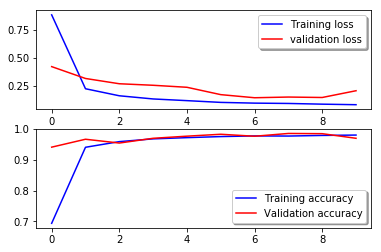

In [29]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Predictions

Loading best weights

In [30]:
model.load_weights('BWeight.md5')

In [31]:
FINAL_PREDS = model.predict_classes(test_data)

In [32]:
results = pd.Series(FINAL_PREDS,name="Label")

In [33]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("mnist_cnn_keras.csv",index=False)